In [18]:
from dotenv import load_dotenv
from IPython.display import display, Image

from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_core.tools.retriever import create_retriever_tool

# For QA-Retriever
from langchain_core.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

# Custom Import
from optcg.vectorstore_logic import check_for_updates_to_rules, create_or_load_vectorstore_optcg_rulebooks



from langsmith import traceable
from langsmith.wrappers import wrap_openai
from openai import OpenAI
openai_client = wrap_openai(OpenAI())


_ = load_dotenv() # Loads the .env file - e.g. the OPENAI_API_KEY

In [19]:
vectorstore = create_or_load_vectorstore_optcg_rulebooks()

Loading existing vector store...


In [ ]:
sample_query = "What is considered private knowledge?"
results = vectorstore.similarity_search(sample_query, k=3)

[result.metadata["source"] + str(result.metadata["page_label"]) + ": " + result.page_content for result in results]

['tournament_rules22: opponent should receive a Warning. \n• Irreparable game states should not result in restarting a game or match. \n• If a player has damaged the game state due to an illegal action or missed auto, and \ngameplay can be rewound to the point of that illegal action, it will be rewound even if the \nopponent would gain an advantage from information that was previously Private \nKnowledge. \n4.11 Public Knowledge \nThe following information is considered to be public knowledge, unless a card effect states \notherwise: \n• The number of cards in a player’s hand; \n• The number of cards in a player’s deck (this includes main and DON!! deck); \n• The number and names of cards in a player’s trash area; \n• The number of Life cards remaining; \n• Information printed on a specific card mentioned by name or otherwise clearly described; \n• Which cards have been played during the current turn. \nPlayers must answer questions involving the above topics truthfully. Players may no

## Simple QA Retriever - Retriever Debugging

In [3]:
# See full prompt at https://smith.langchain.com/hub/rlm/rag-prompt
qa_prompt = PromptTemplate.from_template(
    """
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {input}
    Context: {context} 
    Answer:
    """
)
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
stuff_docs_chain = create_stuff_documents_chain(
    llm=llm,
    prompt=qa_prompt,
)
retrieval_chain = create_retrieval_chain(
    retriever=vectorstore.as_retriever(),
    combine_docs_chain=stuff_docs_chain
)    

retrieval_chain.invoke({"input": "What is considered private knowledge?"})

{'input': 'What is considered private knowledge?',
 'context': [Document(id='c539cb91-5a1a-4cc4-bb16-31352369e3ec', metadata={'creator': 'Microsoft® Word 2021', 'total_pages': 41, 'creationdate': '2025-02-22T22:45:09-05:00', 'page_label': '22', 'producer': 'Microsoft® Word 2021', 'moddate': '2025-06-11T20:02:39+09:00', 'title': 'Tournament Rules Manual', 'source': 'tournament_rules', 'page': 21}, page_content='opponent should receive a Warning. \n• Irreparable game states should not result in restarting a game or match. \n• If a player has damaged the game state due to an illegal action or missed auto, and \ngameplay can be rewound to the point of that illegal action, it will be rewound even if the \nopponent would gain an advantage from information that was previously Private \nKnowledge. \n4.11 Public Knowledge \nThe following information is considered to be public knowledge, unless a card effect states \notherwise: \n• The number of cards in a player’s hand; \n• The number of cards 

## Agent with the Retriever Tool

The base outputs are arguably more reliable and accurate with the `o4-mini` model, however it is significantly slower compared to models like `gpt-4.1-mini` or `gpt-4o-mini`.

:) I think the `gpt-4.1` is a nice middle ground.

In [20]:
rulebook_retriever_tool = create_retriever_tool(
    retriever=vectorstore.as_retriever(), 
    name="rulebooks_retriever",
    description="""Retrieves relevant information from the One Piece TCG rulebooks. This tool is useful for answering questions about the rules of the game, such as how to play, what cards do, and how to resolve specific situations. This is a retrieval tool that will relevant document chunks from the vectorstore, which contains the rulebooks of the One Piece TCG."""
)
rulebook_retriever_tool

Tool(name='rulebooks_retriever', description='Retrieves relevant information from the One Piece TCG rulebooks. This tool is useful for answering questions about the rules of the game, such as how to play, what cards do, and how to resolve specific situations. This is a retrieval tool that will relevant document chunks from the vectorstore, which contains the rulebooks of the One Piece TCG.', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000002C66B846CA0>, retriever=VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x000002C60C562210>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000002C66B8782C0>, retriever=Vect

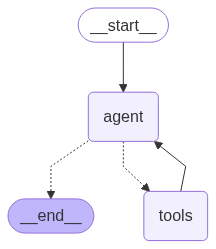

In [77]:
tools = [rulebook_retriever_tool]

@traceable
def build_agent():
    """Builds the agent with the tools and prompt."""
    return create_react_agent(
        model=ChatOpenAI(model="gpt-4.1", temperature=0),
        name="RulebookAgent",
        tools=tools, 
        prompt="You are a helpful assistant that helps people find information in the Rulebook for One Piece TCG, otherwise abbreviated as optcg. You have access to the following tools: {tools}. Use them to find the information the user is looking for. If you don't know the answer, just say you don't know. Do not try to make up an answer. If you cannot find the answer in the rulebooks, tell the user that you cannot find the answer in the rulebooks.",
    )

agent = build_agent()
display(Image(agent.get_graph().draw_mermaid_png()))  # Display the agent's graph structure in Mermaid format

In [64]:
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "What happens if two characters with the same name are played on the same team?"
    }]}
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What happens if two characters with the same name are played on the same team?
================================== Ai Message ==================================
Name: RulebookAgent
Tool Calls:
  rulebooks_retriever (call_fU2GInlO4sEaRElEsQni9Ezc)
 Call ID: call_fU2GInlO4sEaRElEsQni9Ezc
  Args:
    query: Can two characters with the same name be played on the same team? What happens if they are?
================================= Tool Message =================================
Name: rulebooks_retriever

distinguished from one another, a player may be instructed to change sleeves or remove 
them. 
• Players are not allowed to use sleeves that obstruct the front of the card. 
• Sleeves with reflective backs or holographic fronts are not allowed. 
• Sleeves with artwork on the backs, provided all sleeves are identical and are of a non- 
offensive nature, are allowed. 
Players are responsible for ensuring that ca

In [65]:
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "What is the difference between a character and a leader?"
    }]}
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the difference between a character and a leader?
================================== Ai Message ==================================
Name: RulebookAgent
Tool Calls:
  rulebooks_retriever (call_BQvGjL6pX38UBy9DxuE62xpG)
 Call ID: call_BQvGjL6pX38UBy9DxuE62xpG
  Args:
    query: difference between a character and a leader
  rulebooks_retriever (call_YVUzVkdNasubBq0Fx3KSqb1l)
 Call ID: call_YVUzVkdNasubBq0Fx3KSqb1l
  Args:
    query: what is a character card
  rulebooks_retriever (call_R6drb2RXPN9P8rGJ03c7dK3o)
 Call ID: call_R6drb2RXPN9P8rGJ03c7dK3o
  Args:
    query: what is a leader card
================================= Tool Message =================================
Name: rulebooks_retriever

3-7. Character Area 
3-7-1. This is where each player places their Character cards. 
3-7-2. The Character area is an open area. Cards in this area are placed face-up. 
3-7-3. Placing a Character card in the Cha

In [78]:
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "What is the maximum number of cards you can have in your hand at the end of your turn?"
    }]}
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the maximum number of cards you can have in your hand at the end of your turn?
================================== Ai Message ==================================
Name: RulebookAgent
Tool Calls:
  rulebooks_retriever (call_F1At3gljZHiLkeNOkV2QQcog)
 Call ID: call_F1At3gljZHiLkeNOkV2QQcog
  Args:
    query: maximum number of cards in hand at end of turn
================================= Tool Message =================================
Name: rulebooks_retriever

21  
You may not create your own game area layout. It is possible to modify the layout to accommodate 
physical requirements. If you need to modify the game area layout, you must notify your opponent 
and ensure it is obvious to all tournament officials. 
The position of cards must be maintained as they were originally placed on the game area, except 
when directed otherwise by a card effect. 
Each deck should be oriented in a north / south direc